<a href="https://colab.research.google.com/github/DiegoHuesos/Tesis_deteccion_de_ruido_en_imagenes_con_algoritmo_paralelo_de_agrupamiento/blob/master/Experimentacion_Distancias_Precomputadas_Sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimentación con DBSCAN de Sklearn con distancias precomputadas en GPU

En el presente código, se define una función llamada `parallel_calculate_distances` que calcula las distancias entre todos los puntos dados y devuelve una matriz cuadrada de distancias. Esta función llama, a su vez, a una función kernel de GPU llamada `parallel_calculate_distances_kernel` que calcula dichas distancias de forma paralela.

Además, se define una función modificada de sklearn llamada `dbscan_sklearn_modified` que ejecuta, primero, la función de cálculo de distancias y, después, la función de dbscan de sklearn pasando como parámetro la matriz calculada anteriormente.

Posteriormente, se llevan a cabo las experimentaciones con los conjuntos de datos Toy Datasets y los conjuntos sintéticos de distintos tamaños para obtener los tiempos de ejecución y el uso de memoria.

Por último, se hace una comparación entre los tiempos de ejecución y el uso de la memoria entre el cálculo de las distnacias con la función de GPU `parallel_calculate_distances` y la función `pairwise_distances` que es la que sklearn utiliza en su función de DBSCAN.

## Importación de librerías y declaración de funciones para graficar resultados y medir uso de memoria

Instalación de una libraría de Nvidia para poder medir el uso de la VRAM.

In [ ]:
!pip install nvidia-ml-py3

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=d9fa7a6cc593d63de0482c9c56d26746542532b9de9f5b2f5be37ff2e66aeca8
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import time
import json
import psutil
import os
import gc
import pynvml

from numba import cuda
from sklearn import datasets
from sklearn.datasets import make_blobs
from operator import indexOf
from IPython.display import display
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

In [ ]:
def plot_dbscan_results(X_std, labels, core_samples_mask):
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)
        xy = X_std[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)
        xy = X_std[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    plt.title('DBSCAN clustering')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.show()

In [ ]:
def get_memory_usage():
    memory_usage = {}
    memory_stats = psutil.virtual_memory()
    memory_usage['total'] = memory_stats.total / (1024 * 1024)
    memory_usage['available'] = memory_stats.available / (1024 * 1024)
    memory_usage['used'] = memory_stats.used / (1024 * 1024)
    memory_usage['percent_used'] = memory_stats.percent
    memory_usage['process'] = {}
    memory_usage['process']['rss'] = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
    memory_usage['process']['vms'] = psutil.Process(os.getpid()).memory_info().vms / (1024 * 1024)
    return memory_usage

def get_total_memory():
    return psutil.virtual_memory().total / (1024 * 1024)

def get_memory_usage_percentage():
    return psutil.virtual_memory().percent

def get_gpu_memory_info(device_index=0):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)  # Obtiene el handle de la GPU especificada
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)  # Obtiene la información de memoria de la GPU
    gpu_memory_info = {
                          "total_vram_gb": info.total / (1024 ** 3),
                          "used_vram_gb": info.used / (1024 ** 3),
                          "free_vram_gb": info.free / (1024 ** 3)
                      }
    pynvml.nvmlShutdown()
    return gpu_memory_info

def get_gpu_memory_percentage(device_index=0):
    gpu_memory_info = get_gpu_memory_info()
    return round( gpu_memory_info['used_vram_gb'] / gpu_memory_info['total_vram_gb'] * 100, 1 )

def get_cpu_usage():
    cpu_usage = psutil.cpu_percent(interval=1)
    return cpu_usage

def get_disk_usage():
    disk_usage = psutil.disk_usage('/')
    disk_usage_mb = disk_usage.total / (1024 * 1024)
    return disk_usage_mb

## Función y kernel para calcular las distancias con GPU

El kernel llamado `parallel_calculate_distances_kernel` recibe un número entero que indica el tamaño `X_size` de la matriz, asumiendo que la matriz dada es de tamaño 2 por X_size, recibe también la matriz `X` de valores `float64` y una matrix cuadarada de valores `float64` inicializada en ceros llamada `neighbors_matrix`.

La matriz `neighbors_matrix` representa una matriz de adyacencias donde los índices posicionales de cada valor representan la relación entre los dos puntos correspondientes a esos índices en la matriz de puntos `X`.

Así, cuando se calcula la distancia entre el punto `X[i]` y el punto `X[j]`, el núcleo del GPU en la posición `X(i,j)` caclula la distancia entre estos dos puntos y almacena la distancia calculada en `neighbors_matrix[i][j]`.

El kernel obtiene el valor del renglón `row` y columna `col` del núcleo del GPU correspondiente, calcula la distancia euclidiana entre los puntos correspondientes en la posición de los valores [`row`] y [`col`] de la matriz de puntos `X` y ese guarda la distancia calculada en la matriz `neighbors_array` en la posición [`row`, `col`].


\begin{align*}
\begin{bmatrix}
\sqrt{(X_{[0][0]} - X_{[0][0]})^2 + (X_{[0][1]} - X_{[0][1]})^2} & \cdots & \sqrt{(X_{[0][0]} - X_{[col][0]})^2 + (X_{[0][1]} - X_{[col][1]})^2} & \cdots & \sqrt{(X_{[0][0]} - X_{[m][0]})^2 + (X_{[0][1]} - X_{[m][1]})^2}\\
\vdots & \ddots  & \vdots  & \vdots & \vdots  \\
\sqrt{(X_{[row][0]} - X_{[0][0]})^2 + (X_{[row][1]} - X_{[0][1]})^2} & \vdots  & \sqrt{(X_{[row][0]} - X_{[col][0]})^2 + (X_{[row][1]} - X_{[col][1]})^2} & \vdots & \sqrt{(X_{[row][0]} - X_{[m][0]})^2 + (X_{[row][1]} - X_{[m][1]})^2}  \\
\vdots & \vdots  & \vdots  & \ddots & \vdots  \\
\sqrt{(X_{[n][0]} - X_{[0][0]})^2 + (X_{[n][1]} - X_{[0][1]})^2} & \cdots & \sqrt{(X_{[n][0]} - X_{[j][0]})^2 + (X_{[n][1]} - X_{[j][1]})^2} & \cdots & \sqrt{(X_{[n][0]} - X_{[m][0]})^2 + (X_{[n][1]} - X_{[m][1]})^2}\\
\end{bmatrix}
\end{align*}

El kernel `parallel_calculate_distances_kernel` es llamado por la función `parallel_calculate_distances` que recibe como parámetro, únicamente, la matriz de puntos `X`. Esta función se encarga de definir todas las variables necesarias para ejecutar el kernel, copia las variables de la RAM a la VRAM, ejecuta el kernel, copia las variables de vuelta de la VRAM a la RAM y regresa la matriz cuadrada de distancias y un diccionario con la información del uso de la VRAM.

In [ ]:
# Kernel para calcular las distancias entre todos los puntos
@cuda.jit
def parallel_calculate_distances_kernel(X_size, X, neighbors_matrix):
    # Obtener índice del renglón del núcleo
    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    # Obtener índice de la columna del núcleo
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    # Verificar si el índice está dentro del rango de la matriz de puntos
    if row < X_size and col < X_size:
        # Computar distancia euclideana entre par de puntos
        neighbors_matrix[row, col] = math.sqrt((X[row, 0] - X[col, 0]) ** 2 + (X[row, 1] - X[col, 1]) ** 2)

def parallel_calculate_distances(X):

  # Definir variables del host (RAM)
  X_host = X
  X_SIZE_host = X_host.shape
  X_SIZE = X_SIZE_host[0]
  NEIGHBORS_MATRIX_host = np.zeros( (X_SIZE_host[0], X_SIZE_host[0]), dtype=np.float64)

  # Definir variables para el dispositivo (GPU) -> dimensiones del bloque (block) y la rejilla (grid)
  threads_per_block = (16, 16)
  blocks_per_grid_x = math.ceil(X_SIZE_host[0] / threads_per_block[0])
  blocks_per_grid_y = math.ceil(X_SIZE_host[0] / threads_per_block[1])
  blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

  # Transferir las variables de la memoria del host (RAM) a la memoria del dispositivo (VRAM)
  X_device = cuda.to_device(X_host)
  NEIGHBORS_MATRIX_device = cuda.to_device(NEIGHBORS_MATRIX_host)

  # Borrar variables de la memoria del host (RAM)
  del NEIGHBORS_MATRIX_host
  gc.collect()

  # Llamar al kernel para que se ejecute en el dispositivo (GPU) indicando las variables correspondientes
  parallel_calculate_distances_kernel[blocks_per_grid, threads_per_block](X_SIZE, X_device, NEIGHBORS_MATRIX_device)

  # Obtener uso de la VRAM
  gpu_memory_info = get_gpu_memory_percentage()

  # Transferir las variables de la memoria del dispositivo (VRAM) a la memoria del host (RAM)
  NEIGHBORS_MATRIX_host = NEIGHBORS_MATRIX_device.copy_to_host()

  # Borrar las variables de la VRAM
  NEIGHBORS_MATRIX_device = None
  X_device = None

  # Regresar resultados
  return NEIGHBORS_MATRIX_host, gpu_memory_info

## Función modificada dbscan de sklearn


La siguiente función es una adaptación de la función `DBSCAN` de `sklearn` que recibe la matriz de puntos `X`, los valores `eps` y `min_samples`. Esta función llama, a su vez, a la función `calculate_distances` que se encarga de computar las distancias entre los puntos de `X` de forma paralela, después se pasa la matriz de las distancias calculadas como parámetro de la función DBSCAN de Sklearn, y, por último, se regresa el resultado de DBSCAN y el diccionario con el uso de la VRAM.

In [ ]:
def dbscan_sklearn_modified(X, eps, min_samples):
    matriz_distancias, gpu_memory_info = parallel_calculate_distances(X)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    clusters = dbscan.fit(matriz_distancias)
    return clusters, gpu_memory_info

## Experimentación con Toy Datasets

A continuación, se lleva a cabo la experimentación con los conjuntos de datos de muestra de la librería `sklearn` llamados [Toy Datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html).

Los valores óptimos de `eps` y `min_samples` de DBSCAN para cada conjunto de datos fue calculado previamente y sólo es agregado como un valor constante para su utilización en esta experimentación.

Los resultados de este experimento se guardan en el archivo `sklearn_modified_toy_datasets_results.json`.

In [ ]:
# Declarar el diccionario con los conjuntos de datos de Toy Datasets y sus correspondientes valores de eps y num_samples
toy_datasets = {  'iris': {'dataset': datasets.load_iris(), 'eps': 0.199367, 'min_samples': 5},
                  'diabetes': {'dataset': datasets.load_diabetes(), 'eps': 0.014765, 'min_samples': 6},
                  'digits': {'dataset': datasets.load_digits(), 'eps': 1.038251, 'min_samples': 7},
                  'linnerud': {'dataset': datasets.load_linnerud(), 'eps': 41.911597, 'min_samples': 2},
                  'wine': {'dataset': datasets.load_wine(), 'eps': 16.622963, 'min_samples': 5},
                  'breast_cancer': {'dataset': datasets.load_breast_cancer(), 'eps': 42.689478, 'min_samples': 6}
                }

# Iterar por cada conjunto de datos de Toy Datasets
for dataset_name, _ in toy_datasets.items():

    # Imprimir el nombre del conjunto de datos para el control de la ejecución
    print('Dataset: ', dataset_name)

    # Cargar el conjunto de datos
    Y = toy_datasets[dataset_name]['dataset'].data
    Y = np.ascontiguousarray(Y)

    # Reducir la dimensión del conjunto de datos a sólo dos características
    pca = PCA(n_components=2)
    X_std = pca.fit_transform(Y)
    X_std = np.ascontiguousarray(X_std)

    # Eliminar el dataset del diccionario y Y
    del Y, toy_datasets[dataset_name]['dataset']
    gc.collect()

    # Obtener los valores de eps y min_samples
    eps = toy_datasets[dataset_name]['eps']
    min_samples = toy_datasets[dataset_name]['min_samples']

    # Almacenar la forma (dimensionalidad) del conjunto de datos e inicializar el diccionario de experimentos
    toy_datasets[dataset_name]['shape'] = X_std.shape
    toy_datasets[dataset_name]['experiment'] = {}

    # Repetir el experimento para poder verificar que siempre de los mismos resultados el algoritmo DBSCAN
    # y obtener tiempos de ejecución y uso de memoria.
    for i in range(10):

      # Obtener tiempo inicial
      start_time = time.time()

      # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
      db, gpu_memory_info = dbscan_sklearn_modified(X_std, eps, min_samples)

      # Obtener el tiempo final y la diferencia para obtener el tiempo de ejecución
      execution_time = time.time() - start_time

      # Obtener los resultados
      labels = db.labels_
      n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
      core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
      core_samples_mask[db.core_sample_indices_] = True
      n_core_points = int(sum(core_samples_mask))
      n_noise = list(labels).count(-1)

      # Guardar los resultados en el diccionario
      toy_datasets[dataset_name]["experiment"][i] = {
          "execution_time": execution_time,
          "memory_usage": get_memory_usage_percentage(),
          "gpu_memory_usage": gpu_memory_info,
          "clusters": n_clusters,
          "core_points": n_core_points,
          "unclassified_points": n_noise
      }

# Guardar resultados de DBSCAN en un archivo JSON para usarlos como referencia en el análisis posterior
file_name = 'sklearn_modified_toy_datasets_results.json'
with open(file_name, 'w') as file:
    json.dump(toy_datasets, file, indent=4)
    print(f"Resultados guardados en {file_name}")

Dataset:  iris


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Dataset:  diabetes
Dataset:  digits
Dataset:  linnerud


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Dataset:  wine
Dataset:  breast_cancer
Resultados guardados en sklearn_modified_toy_datasets_results.json


## Experimentación con conjuntos de datos sintéticos de distintos tamaños

A continuación, se lleva a cabo la experimentación con los conjuntos de datos sintéticos de distintos tamaños: 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000 y 50000 puntos de dos dimensiones que se generaron utilizando la función `make_blobs` de la librería `sklearn.datasets`.

Los valores óptimos de `eps` y `min_samples` de DBSCAN para cada conjunto de datos fue calculado previamente y sólo es agregado como un valor constante para su utilización en esta experimentación.

Los resultados de este experimento se guardan en el archivo `sklearn_modified_different_size_results.json`.


In [ ]:
# Declarar los valores de eps y min_samples óptimos para cada conjunto de datos
datasets_eps_min_samples = {  5000: {'epsilon': 0.4, 'min_samples': 6},
                              10000: {'epsilon': 0.6, 'min_samples': 5},
                              15000: {'epsilon': 0.8, 'min_samples': 4},
                              20000: {'epsilon': 0.8, 'min_samples': 6},
                              25000: {'epsilon': 0.9, 'min_samples': 4},
                              30000: {'epsilon': 0.8, 'min_samples': 2},
                              35000: {'epsilon': 0.8, 'min_samples': 3},
                              40000: {'epsilon': 0.8, 'min_samples': 5},
                              45000: {'epsilon': 0.8, 'min_samples': 9},
                              50000: {'epsilon': 0.6, 'min_samples': 6} }

# Declarar diccionario para almacenar los resultados de la experimentación
different_size_datasets = {}

# Iterar por cada conjunto de datos
for num_samples in range(5000, 20001, 5000):

    # Imprimir el nombre del conjunto de datos para el control de la ejecución
    print('Dataset: ', num_samples)

    # Construir el nombre del archivo JSON del dataset correspondiente
    filename = './datasets/dataset_' + str(num_samples) + '.json'

    # Abrir el archivo JSON correspondiente para cargar los datos del conjunto de datos correspondiente
    with open(filename, 'r') as f:
        data = json.load(f)

    # Obtener los datos, el valor eps y min_samples
    dataset_name = str(num_samples)
    X = np.array(data[dataset_name])
    eps = datasets_eps_min_samples[num_samples]['epsilon']
    min_samples = datasets_eps_min_samples[num_samples]['min_samples']

    # Borrar data de la memoria RAM
    del data
    gc.collect()

    # Guardar los resultados en el diccionario
    different_size_datasets[num_samples] = {}
    different_size_datasets[num_samples]['experiment'] = {}

    # Repetir el experimento para poder verificar que siempre de los mismos resultados el algoritmo DBSCAN
    # y obtener tiempos de ejecución y uso de memoria.
    for i in range(2):

      # Obtener tiempo inicial
      start_time = time.time()

      # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
      db, gpu_memory_info = dbscan_sklearn_modified(X, eps, min_samples)

      # Obtener el tiempo final y la diferencia para obtener el tiempo de ejecución
      execution_time = time.time() - start_time

      # Obtener los resultados
      labels = db.labels_.tolist()
      n_clusters = int(len(set(labels)) - (1 if -1 in labels else 0))
      core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
      core_samples_mask[db.core_sample_indices_] = True
      n_core_points = int(sum(core_samples_mask))
      n_noise = int(list(labels).count(-1))

      # Guardar los resultados en el diccionario
      different_size_datasets[num_samples]["experiment"][i] = {
          "execution_time": execution_time,
          "memory_usage": get_memory_usage_percentage(),
          "gpu_memory_usage": gpu_memory_info,
          "clusters": n_clusters,
          "core_points": n_core_points,
          "unclassified_points": n_noise
      }

      # Eliminar los resultados de DBSCAN de la memoria RAM
      del db, gpu_memory_info
      gc.collect()

    # Delete X, db from memory
    del X
    gc.collect()

# Guardar resultados de DBSCAN en un archivo JSON para usarlos como referencia en el análisis posterior
file_name = 'sklearn_modified_different_size_results.json'
with open(file_name, 'w') as file:
    json.dump(different_size_datasets, file, indent=4)
    print(f"Resultados guardados en {file_name}")

Dataset:  5000
Dataset:  10000
Dataset:  15000
Dataset:  20000
Dataset:  25000


## Medición de tiempo y memoria del cálculo de las distancias

In [ ]:
# Declarar los valores de eps y min_samples óptimos para cada conjunto de datos
datasets_eps_min_samples = {  5000: {'epsilon': 0.4, 'min_samples': 6},
                              10000: {'epsilon': 0.6, 'min_samples': 5},
                              15000: {'epsilon': 0.8, 'min_samples': 4},
                              20000: {'epsilon': 0.8, 'min_samples': 6},
                              25000: {'epsilon': 0.9, 'min_samples': 4},
                              30000: {'epsilon': 0.8, 'min_samples': 2},
                              35000: {'epsilon': 0.8, 'min_samples': 3},
                              40000: {'epsilon': 0.8, 'min_samples': 5},
                              45000: {'epsilon': 0.8, 'min_samples': 9},
                              50000: {'epsilon': 0.6, 'min_samples': 6} }

### Medición de tiempo y memoria al ejecutar el cálculo de las distancias con la función pairwise de sklearn

La función `DBSCAN` de `sklearn` utiliza la función `sklearn.metrics.pairwise_distances` para el cálculo de las distancias entre los puntos, razón por la cual, se ha decidido llevar a cabo la siguiente experimentación para obtener el tiempo de ejecución y el uso de memoria con los conjuntos de datos de diferentes tamaños para su posterior comparación y análisis.

In [ ]:
# Declarar diccionario para almacenar los resultados de la experimentación
pairwise_results = {}
num_samples = 5000

# Iterar por cada conjunto de datos
while num_samples <= 26000:
    print(num_samples)
    # Inicializar la lista para almacenar los resultados de las 30 ejecuciones
    results_30_runs = {'memory': [], 'time': []}

    for run in range(30):  # Bucle para repetir la experimentación 30 veces
        # Construir el nombre del archivo JSON del dataset correspondiente
        dataset_name = str(num_samples)
        filename = './datasets/dataset_' + str(num_samples) + '.json'

        # Abrir el archivo JSON correspondiente para cargar los datos del conjunto de datos correspondiente
        with open(filename, 'r') as f:
            data = json.load(f)

        # Obtener los datos, el valor eps y min_samples
        X = np.array(data[dataset_name])
        eps = datasets_eps_min_samples[num_samples]['epsilon']
        min_samples = datasets_eps_min_samples[num_samples]['min_samples']

        # Borrar data de la memoria RAM
        del data
        gc.collect()

        # Obtener tiempo inicial
        start_time = time.time()
        # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
        matrix_distances = pairwise_distances(X, metric='euclidean')
        # Obtener el tiempo final y la diferencia para obtener el tiempo de ejecución
        end_time = time.time() - start_time

        # Almacenar los resultados de esta ejecución en la lista
        results_30_runs['memory'].append(get_memory_usage_percentage())
        results_30_runs['time'].append(end_time)

        # Eliminar los resultados de DBSCAN de la memoria RAM
        del X, matrix_distances
        gc.collect()

    # Almacenar el promedio de los resultados de las 30 ejecuciones
    pairwise_results[num_samples] = {}
    pairwise_results[num_samples]['memory'] = sum(results_30_runs['memory']) / 30
    pairwise_results[num_samples]['time'] = sum(results_30_runs['time']) / 30

    # Incrementar el número de puntos en 5000
    num_samples += 5000

# Mostrar los resultados
display(pairwise_results)

5000
10000
15000
20000
25000


{5000: {'memory': 13.096666666666664, 'time': 0.3795752684275309},
 10000: {'memory': 17.576666666666664, 'time': 1.3695599555969238},
 15000: {'memory': 24.363333333333333, 'time': 2.8180805762608845},
 20000: {'memory': 34.493333333333325, 'time': 4.919154262542724},
 25000: {'memory': 47.76333333333333, 'time': 7.435600463549296}}

In [ ]:
pairwise_results = {5000: {'memory': 13.096666666666664, 'time': 0.3795752684275309},
                    10000: {'memory': 17.576666666666664, 'time': 1.3695599555969238},
                    15000: {'memory': 24.363333333333333, 'time': 2.8180805762608845},
                    20000: {'memory': 34.493333333333325, 'time': 4.919154262542724},
                    25000: {'memory': 47.76333333333333, 'time': 7.435600463549296}}

### Medición de tiempo y memoria al ejecutar el cálculo de las distancias con la función paralela en GPU

Tanto la función modificada de sklearn llamada `dbscan_sklearn_modified` como la función paralela de dbscan implementada en otro notebook utilizan la función paralela del cálculo de distancias `parallel_calculate_distances`, por lo cual, se ha decidido llevar a cabo la siguiente experimentación para obtener el tiempo de ejcución y el uso de memoria con los conjuntos de datos de diferentes tamaños para su posterior comparación y análisis.

In [ ]:
# Declarar diccionario para almacenar los resultados de la experimentación
gpu_results = {}
num_samples = 5000

# Iterar por cada conjunto de datos
while num_samples <= 26000:
    print(num_samples)
    # Construir el nombre del archivo JSON del dataset correspondiente
    dataset_name = str(num_samples)
    filename = './datasets/dataset_' + str(num_samples) + '.json'
    with open(filename, 'r') as f:
        data = json.load(f)

    # Obtener los datos, el valor eps y min_samples
    X = np.array(data[dataset_name])
    eps = datasets_eps_min_samples[num_samples]['epsilon']
    min_samples = datasets_eps_min_samples[num_samples]['min_samples']

    # Borrar data de la memoria RAM
    del data
    gc.collect()

    # Obtener tiempo inicial
    start_time = time.time()
    # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
    matrix_distances, gpu_memory_info = parallel_calculate_distances(X)
    # Obtener el tiempo final y la diferencia para obtener el tiempo de ejecución
    end_time = time.time() - start_time

    # Obtener los resultados
    gpu_results[num_samples] = {}
    gpu_results[num_samples]['memory'] = get_memory_usage_percentage()
    gpu_results[num_samples]['gpu'] = gpu_memory_info
    gpu_results[num_samples]['time'] = end_time

    # Eliminar los resultados de DBSCAN de la memoria RAM
    del X
    gc.collect()

    # Incrementar el número de puntos en 5000
    num_samples += 5000

# Mostrar los resultados
display(gpu_results)

5000
10000
15000
20000
25000


{5000: {'memory': 14.1, 'gpu': 4.5, 'time': 1.2529664039611816},
 10000: {'memory': 20.0, 'gpu': 9.2, 'time': 0.6796040534973145},
 15000: {'memory': 31.8, 'gpu': 19.7, 'time': 1.3781461715698242},
 20000: {'memory': 49.8, 'gpu': 38.3, 'time': 2.5031678676605225},
 25000: {'memory': 72.9, 'gpu': 32.4, 'time': 4.474653720855713}}

In [ ]:
gpu_results_V100 = { 5000: {'memory': 14.1, 'gpu': 4.5, 'time': 1.2529664039611816},
                10000: {'memory': 20.0, 'gpu': 9.2, 'time': 0.6796040534973145},
                15000: {'memory': 31.8, 'gpu': 19.7, 'time': 1.3781461715698242},
                20000: {'memory': 49.8, 'gpu': 38.3, 'time': 2.5031678676605225},
                25000: {'memory': 72.9, 'gpu': 32.4, 'time': 4.474653720855713}}

In [ ]:
# Declarar diccionario para almacenar los resultados de la experimentación
gpu_results = {}
num_samples = 5000

# Iterar por cada conjunto de datos
while num_samples <= 43000:
    print(num_samples)
    # Inicializar la lista para almacenar los resultados de las 30 ejecuciones
    results_30_runs = {'memory': [], 'gpu': [], 'time': []}

    for run in range(30):  # Bucle para repetir la experimentación 30 veces
        # Construir el nombre del archivo JSON del dataset correspondiente
        dataset_name = str(num_samples)
        filename = './datasets/dataset_' + str(num_samples) + '.json'
        with open(filename, 'r') as f:
            data = json.load(f)

        # Obtener los datos, el valor eps y min_samples
        X = np.array(data[dataset_name])
        eps = datasets_eps_min_samples[num_samples]['epsilon']
        min_samples = datasets_eps_min_samples[num_samples]['min_samples']

        # Borrar data de la memoria RAM
        del data
        gc.collect()

        # Obtener tiempo inicial
        start_time = time.time()
        # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
        matrix_distances, gpu_memory_info = parallel_calculate_distances(X)
        # Obtener el tiempo final y la diferencia para obtener el tiempo de ejecución
        end_time = time.time() - start_time

        # Almacenar los resultados de esta ejecución en la lista
        results_30_runs['memory'].append(get_memory_usage_percentage())
        results_30_runs['gpu'].append(gpu_memory_info)
        results_30_runs['time'].append(end_time)

        # Eliminar los resultados de DBSCAN de la memoria RAM
        del X, matrix_distances
        gc.collect()

    # Almacenar el promedio de los resultados de las 30 ejecuciones
    gpu_results[num_samples] = {
        'memory': sum(results_30_runs['memory']) / 30,
        'gpu': sum(results_30_runs['gpu']) / 30,
        'time': sum(results_30_runs['time']) / 30
    }

    # Incrementar el número de puntos en 5000
    num_samples += 5000

# Mostrar los resultados
display(gpu_results)


5000
10000
15000
20000
25000
30000
35000
40000


{5000: {'memory': 4.200000000000002, 'gpu': 8.25, 'time': 0.25065728028615314},
 10000: {'memory': 5.226666666666666, 'gpu': 18.19, 'time': 0.67879745165507},
 15000: {'memory': 7.029999999999999, 'gpu': 20.56, 'time': 1.37177259127299},
 20000: {'memory': 9.593333333333334,
  'gpu': 32.449999999999996,
  'time': 2.334788187344869},
 25000: {'memory': 12.893333333333329,
  'gpu': 33.600000000000016,
  'time': 3.5761470715204875},
 30000: {'memory': 16.903333333333325,
  'gpu': 46.400000000000006,
  'time': 5.164984726905823},
 35000: {'memory': 21.69333333333334,
  'gpu': 61.59999999999997,
  'time': 6.9739895502726235},
 40000: {'memory': 27.30333333333332, 'gpu': 79.0, 'time': 9.10740832487742}}

In [ ]:
gpu_T4_results = {  5000: {'memory': 4.586666666666664, 'gpu': 6.246666666666667, 'time': 0.25076115926106773},
                    10000: {'memory': 5.639999999999997, 'gpu': 14.676666666666673, 'time': 0.676339586575826},
                    15000: {'memory': 7.5, 'gpu': 19.276666666666674, 'time': 1.3839536825815837},
                    20000: {'memory': 10.04, 'gpu': 22.573333333333338, 'time': 2.396489644050598},
                    25000: {'memory': 13.32666666666667, 'gpu': 33.399999999999984, 'time': 3.640500020980835},
                    30000: {'memory': 17.379999999999995, 'gpu': 47.09999999999999, 'time': 5.216889230410258},
                    35000: {'memory': 22.106666666666676, 'gpu': 63.20000000000003, 'time': 7.109144163131714},
                    40000: {'memory': 27.60666666666668, 'gpu': 81.90000000000005, 'time': 9.319415966669718}}

gpu_V100_results = {  5000: {'memory': 4.200000000000002, 'gpu': 8.25, 'time': 0.25065728028615314},
                      10000: {'memory': 5.226666666666666, 'gpu': 18.19, 'time': 0.67879745165507},
                      15000: {'memory': 7.029999999999999, 'gpu': 20.56, 'time': 1.37177259127299},
                      20000: {'memory': 9.593333333333334, 'gpu': 32.449999999999996, 'time': 2.334788187344869},
                      25000: {'memory': 12.893333333333329,'gpu': 33.600000000000016, 'time': 3.5761470715204875},
                      30000: {'memory': 16.903333333333325, 'gpu': 46.400000000000006,'time': 5.164984726905823},
                      35000: {'memory': 21.69333333333334, 'gpu': 61.59999999999997, 'time': 6.9739895502726235},
                      40000: {'memory': 27.30333333333332, 'gpu': 79.0, 'time': 9.10740832487742}}

### Comparación de tiempo y memoria del cálculo de las distancias

A continuación, se grafican los tiempos de ejecución del cálculo de las distancias entre la función `pairwise` y la función `parallel_calculate_distances` para diferentes conjuntos de datos de diferentes tamaños.

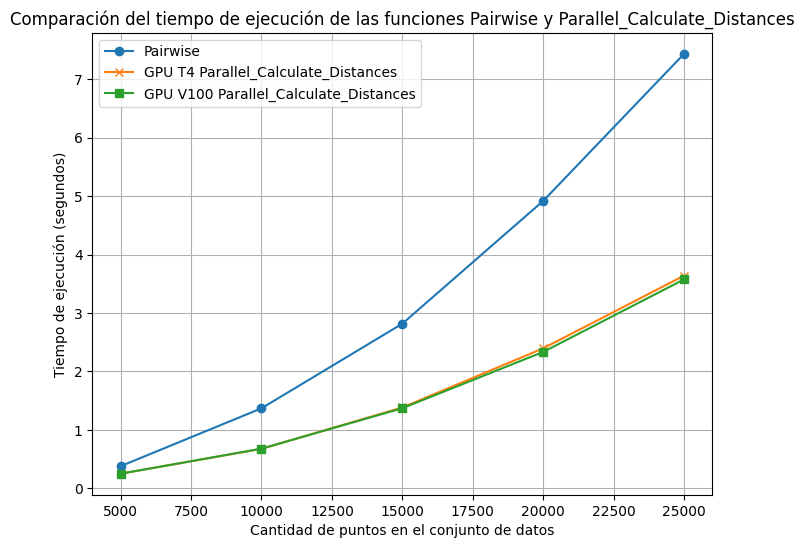

In [ ]:
# Crear listas de puntos y tiempos de ejecución
points = list(pairwise_results.keys())
pairwise_times = [pairwise_results[point]['time'] for point in points]
gpu_T4_times = [gpu_T4_results[point]['time'] for point in points]
gpu_V100_times = [gpu_V100_results[point]['time'] for point in points]

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(points, pairwise_times, label='Pairwise', marker='o')
plt.plot(points, gpu_T4_times, label='GPU T4 Parallel_Calculate_Distances', marker='x')
plt.plot(points, gpu_V100_times, label='GPU V100 Parallel_Calculate_Distances', marker='s')
plt.xlabel('Cantidad de puntos en el conjunto de datos')
plt.ylabel('Tiempo de ejecución (segundos)')
plt.title('Comparación del tiempo de ejecución de las funciones Pairwise y Parallel_Calculate_Distances')
plt.legend()
plt.grid(True)
plt.show()

Como podemos observar en la gráfica anterior, la función `pairwise` tarda más tiempo en ejecutar el cálculo de las distancias que la función `parallel_calculate_distances` paralela para todos los conjuntos de datos, sin embargo,  esta diferencia es más evidente conforme la cantidad de puntos en el conjunto de datos aumenta. Estos resultados tienen sentido debido a que el cálculo de las distancias de forma serial aumenta de forma lineal su tiempo de ejecución, mientras que el cálculo paralelo incrementa el tiempo de ejecución con una pendiente menor. Además, si el conjunto de datos es pequeño, la sobrecarga que implica la transmición y copia de información entre la RAM y VRAM es contraproducente, pero conforme la cantidad de puntos aumenta, esta sobrecarga comienza a ser insignificante. Podemos ver que alrededor de los 9000 puntos se ubica el punto de inflexión donde la función paralela es más eficiente que la serial.

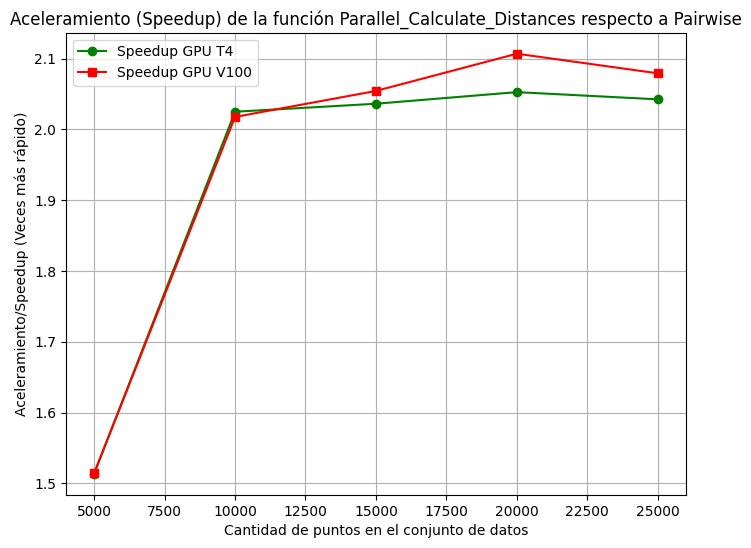

In [ ]:
# Calcular el speedup como la relación del tiempo de ejecución pairwise sobre el tiempo de ejecución en GPU
speedup_T4 = [pairwise / gpu for pairwise, gpu in zip(pairwise_times, gpu_T4_times)]
speedup_V100 = [pairwise / gpu for pairwise, gpu in zip(pairwise_times, gpu_V100_times)]

# Graficar el speedup
plt.figure(figsize=(8, 6))
plt.plot(points, speedup_T4, label='Speedup GPU T4', marker='o', color='green')
plt.plot(points, speedup_V100, label='Speedup GPU V100', marker='s', color='red')
plt.xlabel('Cantidad de puntos en el conjunto de datos')
plt.ylabel('Aceleramiento/Speedup (Veces más rápido)')
plt.title('Aceleramiento (Speedup) de la función Parallel_Calculate_Distances respecto a Pairwise')
plt.grid(True)
plt.legend()
plt.show()

En la gráfica anterior, podemos observar el aceleramiento del cálculo de las distancias de forma paralela con la función `parallel_calculate_distances` respecto a la función serial `pairwise`. Si bien, el comportamiento de la gráfica no es lineal, todos los valores de aceleramiento después de los 9000 puntos sí se encuentran por encima del valor `1.0` lo que indica un aceleramiento.

Las razones por las cuales el aceleramiento de un conjnunto de datos respecto varia puede tener diversas razones como la sobrecarga, la distribución de los puntos, y la relación con las características de la rejilla de la GPU.

Podemos observar que las caídas de los valores del aceleramiento, se encuentran cuando las cantidades de puntos de los conjuntos de datos contienen 5000 en su cifra como en el 15000, 25000 y 35000, mientras que en los demás casos como en el 10000, 20000, 30000 y 40000 hay subidas en el aceleramiento.

La disminución del aceleramiento en ciertos tamaños de datos podría deberse a varios factores: alineación de memoria ineficiente que no coincide con la arquitectura de la GPU, sobrecarga adicional en la preparación de datos o inicialización de procesos, distribución desigual del trabajo entre los hilos de la GPU, interacción desfavorable entre el conjunto de datos y la caché de la GPU que resulta en fallos de caché, o limitaciones en el ancho de banda de comunicación que ralentizan la transferencia de datos. Identificar la causa exacta requeriría un análisis de perfilado detallado del código y el hardware.

De cualquier forma, podemos observar que existe una tendencia de crecimiento del aceleramiento conforme aumenta la cantidad de datos en los conjuntos.

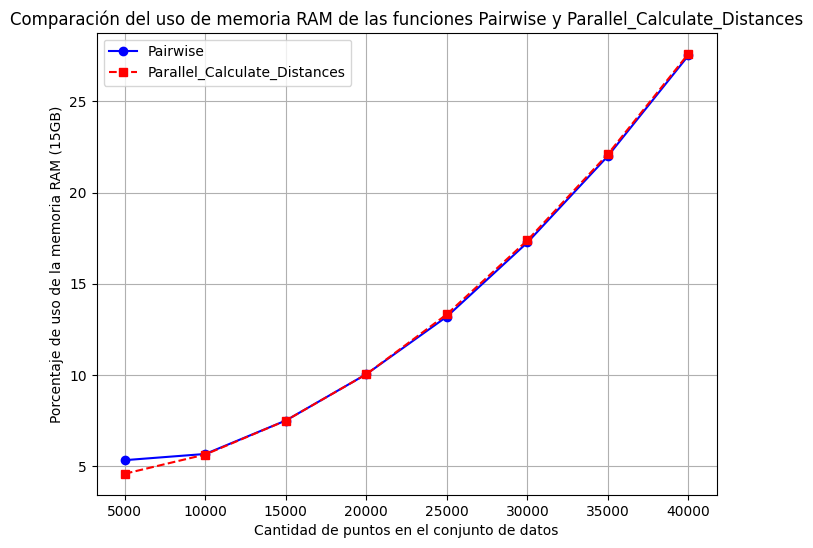

In [ ]:
# Extrayendo las claves y los valores de memoria
keys = list(pairwise_results.keys())
pairwise_memory = [val['memory'] for val in pairwise_results.values()]
gpu_T4_memory = [val['memory'] for val in gpu_results.values()]


# Creando el gráfico
plt.figure(figsize=(8, 6))

# Graficando cada diccionario
plt.plot(keys, pairwise_memory, marker='o', linestyle='-', color='blue', label='Pairwise')
plt.plot(keys, gpu_memory, marker='s', linestyle='--', color='red', label='Parallel_Calculate_Distances')

# Añadiendo títulos y leyendas
plt.title('Comparación del uso de memoria RAM de las funciones Pairwise y Parallel_Calculate_Distances')
plt.xlabel('Cantidad de puntos en el conjunto de datos')
plt.ylabel('Porcentaje de uso de la memoria RAM (12.7 GB)')
plt.legend()

# Mostrando el gráfico
plt.grid(True)
plt.show()

La gráfica anterior muestra una comparativa entre el uso de memoria RAM de la función `pairwise` y la función paralela `parallel_calculate_distances`. Podemos observar que, en este caso, ambas funciones utilizan, prácticamente, el mismo espacio de memoria RAM porque las estructuras de datos y variables que emplean en memoria RAM son las mismas con un poco más de memoria empleada con la función paralela porque utiliza ciertas variables para definir las caracterísiticas de ejecución en la GPU.

Además de esto, es evidente notar un pico inicial de memoria por parte de la función paralela cuando se ejecuta el experimento con 5000 puntos. Esto se puede deber a muchas razones como una configuración subóptima para un conjunto de datos pequeño, sobrecargas adicionales en las estructuras de datos, fragmentación de memoria, grandes transferencias de datos iniciales, o algoritmos con requerimientos de memoria que varían de manera no lineal con el tamaño del problema.

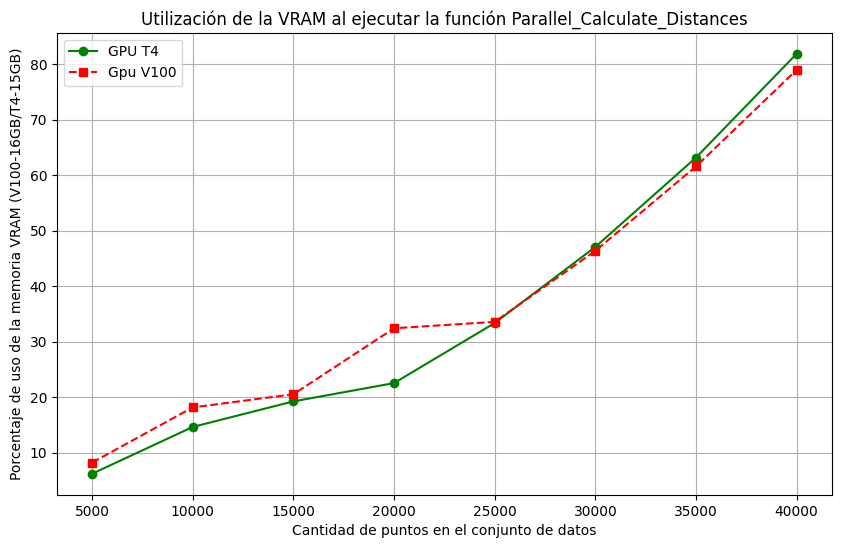

In [ ]:
# Extrayendo las claves (keys) y los valores de "gpu"
keys = list(gpu_T4_results.keys())
gpu_T4_values = [val['gpu'] for val in gpu_T4_results.values()]
gpu_V100_values = [val['gpu'] for val in gpu_V100_results.values()]


# Creando el gráfico
plt.figure(figsize=(10, 6))

# Graficando
plt.plot(keys, gpu_T4_values, marker='o', linestyle='-', color='green', label='GPU T4')
plt.plot(keys, gpu_V100_values, marker='s', linestyle='--', color='red', label='Gpu V100')

# Añadiendo títulos y leyendas
plt.title('Utilización de la VRAM al ejecutar la función Parallel_Calculate_Distances')
plt.xlabel('Cantidad de puntos en el conjunto de datos')
plt.ylabel('Porcentaje de uso de la memoria VRAM (V100-16GB/T4-15GB)')
plt.legend()

# Mejoras visuales
plt.grid(True)
plt.xticks(keys)  # Asegura que cada clave tenga una marca en el eje X
plt.show()

En la gráfica anterior, se muestra el porcentaje de uso de la memoria VRAM al emplear la función paralela `parallel_calculate_distances`. Se puede observar que con 11000 puntos hay una ocupación del 10% de la VRAM, con 31000 puntos hay una ocupación del 50% y con 39000 puntos hay una ocupación de 80% considerando que la memoria VRAM de la GPU T4 de Nvidia tiene una capacidad de 16GB. Con 45000 el programa se veía interrumpido por saturación de memoria.